In [9]:
%reload_ext autoreload
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnvWrapper
import numpy as np
%reload_ext autoreload
from Wordle import WordleEnv
from stable_baselines3.common import monitor

# Create a vectorized environment for training with `imitation`
env = monitor.Monitor(WordleEnv())
venv = DummyVecEnv([lambda: RolloutInfoWrapper(env)])  # Wrap a single environment -- only useful for simple testing like this
venv.render_mode = 'human'

In [23]:
%reload_ext autoreload
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnvWrapper
import numpy as np
%reload_ext autoreload
from Wordle import WordleEnv
from stable_baselines3.common import monitor
from imitation.algorithms import bc
from stable_baselines3.common.policies import ActorCriticPolicy
import os
import imageio
from stable_baselines3.common.evaluation import evaluate_policy
from IPython.display import clear_output
import sys

class OutputCapturer:
    def __init__(self, filename):
        self.filename = filename

    def __enter__(self):
        self.old_stdout = sys.stdout
        self.file = open(self.filename, 'w')
        sys.stdout = self.file
        return self.file

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self.old_stdout
        self.file.close()
        
env = monitor.Monitor(WordleEnv())
venv = DummyVecEnv([lambda: RolloutInfoWrapper(env)])  # Wrap a single environment -- only useful for simple testing like this
venv.render_mode = 'human'

rng = np.random.default_rng()
rollouts = np.load('data/trajectories_all.npy', allow_pickle=True)
transitions = rollout.flatten_trajectories_with_rew(rollouts)

res = []
checkpoint_arr = os.listdir("checkpoints/")  # Example checkpoint path
for i in range(len(checkpoint_arr)):
    print()
    checkpoint_path = f"checkpoints/[checkpoint_arr[i]]"  # Example checkpoint path

    loaded_policy = ActorCriticPolicy.load(checkpoint_path)

    bc_trainer = bc.BC(
        observation_space=env.observation_space,
        action_space=env.action_space,
        demonstrations=transitions,
        rng=rng,
        policy=loaded_policy
    )
    eps = 100
    # Use the loaded policy
    with OutputCapturer(f"results/[(i+1)*50]_epochs.txt"):
        reward_after_training, ep_length = evaluate_policy(bc_trainer.policy, venv, n_eval_episodes=eps, render=True, return_episode_rewards=True)
        reward_after_training = [0 if x <= 0 else 10 for x in reward_after_training]
        n = len(ep_length)
        fails = ep_length.count(7)
        acc = ((n - fails)/n)*100
        print(f"Win rate: [acc]%")
        print(f"Average number of guesses: [np.mean(ep_length)]")
    res.append([(i+1)*50, acc, np.mean(ep_length)])
    clear_output(wait=True)
    
display(res)

[{3.66, 50, 94.0},
 {3.63, 95.0, 100},
 {3.52, 96.0, 150},
 {3.57, 96.0, 200},
 {3.56, 96.0, 250},
 {3.59, 96.0, 300},
 {3.56, 94.0, 350},
 {3.44, 97.0, 400},
 {3.63, 95.0, 450},
 {3.72, 90.0, 500},
 {3.65, 92.0, 550},
 {3.47, 99.0, 600},
 {3.55, 98.0, 650},
 {3.51, 97.0, 700},
 {3.63, 96.0, 750},
 {3.78, 92.0, 800},
 {3.48, 96.0, 850},
 {3.69, 96.0, 900},
 {3.5, 97.0, 950},
 {3.54, 97.0, 1000}]

In [29]:
import pandas as pd
arr = [[3.66, 94.0, 50],
 [3.63, 95.0, 100],
 [3.52, 96.0, 150],
 [3.57, 96.0, 200],
 [3.56, 96.0, 250],
 [3.59, 96.0, 300],
 [3.56, 94.0, 350],
 [3.44, 97.0, 400],
 [3.63, 95.0, 450],
 [3.72, 90.0, 500],
 [3.65, 92.0, 550],
 [3.47, 99.0, 600],
 [3.55, 98.0, 650],
 [3.51, 97.0, 700],
 [3.63, 96.0, 750],
 [3.78, 92.0, 800],
 [3.48, 96.0, 850],
 [3.69, 96.0, 900],
 [3.5, 97.0, 950],
 [3.54, 97.0, 1000]]

columns = ["guesses", "acc", "epc"]
df = pd.DataFrame(arr, columns=columns)

cols = list(df.columns)
cols.insert(0, cols.pop(2))  # Move the third column to the first position

df = df[cols].set_index(cols[0])
display(df)

,guesses,acc
epc,,
50,3.66,94.0
100,3.63,95.0
150,3.52,96.0
200,3.57,96.0
250,3.56,96.0
300,3.59,96.0
350,3.56,94.0
400,3.44,97.0
450,3.63,95.0


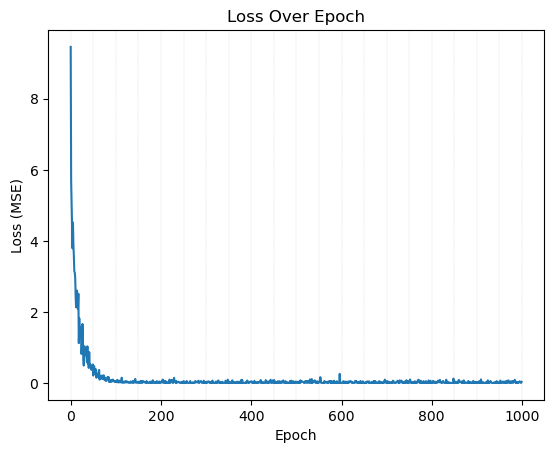

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('extracted_data.csv')
plt.plot(df.index, df['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss Over Epoch')

for i in range (0, 21):
    plt.axvline(x=i*50, color='grey', linestyle='--', linewidth=0.1)  # Customize line properties as needed
plt.show()

In [46]:
from stable_baselines3.common.evaluation import evaluate_policy

rng = np.random.default_rng()
rollouts = np.load('data/trajectories_all.npy', allow_pickle=True)
transitions = rollout.flatten_trajectories_with_rew(rollouts)

In [ ]:
from imitation.algorithms import bc

bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
)
reward_before_training, _ = evaluate_policy(bc_trainer.policy, venv, 100, return_episode_rewards=True)
print(f"Reward before training: [np.mean(reward_before_training)]")

In [5]:
bc_trainer.train(n_epochs=100000)

161496batch [2:25:47, 58.40batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 161500    |
|    ent_loss       | -3.91e-05 |
|    entropy        | 0.0391    |
|    epoch          | 656       |
|    l2_loss        | 0         |
|    l2_norm        | 1.77e+05  |
|    loss           | 0.0336    |
|    neglogp        | 0.0336    |
|    prob_true_act  | 0.979     |
|    samples_so_far | 5168032   |
---------------------------------


161998batch [2:25:57, 53.29batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 162000    |
|    ent_loss       | -1.66e-06 |
|    entropy        | 0.00166   |
|    epoch          | 658       |
|    l2_loss        | 0         |
|    l2_norm        | 1.77e+05  |
|    loss           | 0.000147  |
|    neglogp        | 0.000149  |
|    prob_true_act  | 1         |
|    samples_so_far | 5184032   |
---------------------------------


162496batch [2:26:06, 54.94batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 162500    |
|    ent_loss       | -4.19e-06 |
|    entropy        | 0.00419   |
|    epoch          | 660       |
|    l2_loss        | 0         |
|    l2_norm        | 1.77e+05  |
|    loss           | 0.000623  |
|    neglogp        | 0.000628  |
|    prob_true_act  | 0.999     |
|    samples_so_far | 5200032   |
---------------------------------


162994batch [2:26:15, 57.34batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 163000    |
|    ent_loss       | -1.42e-06 |
|    entropy        | 0.00142   |
|    epoch          | 662       |
|    l2_loss        | 0         |
|    l2_norm        | 1.78e+05  |
|    loss           | 0.000129  |
|    neglogp        | 0.000131  |
|    prob_true_act  | 1         |
|    samples_so_far | 5216032   |
---------------------------------


163494batch [2:26:24, 60.12batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 163500    |
|    ent_loss       | -0.000102 |
|    entropy        | 0.102     |
|    epoch          | 664       |
|    l2_loss        | 0         |
|    l2_norm        | 1.78e+05  |
|    loss           | 0.11      |
|    neglogp        | 0.111     |
|    prob_true_act  | 0.939     |
|    samples_so_far | 5232032   |
---------------------------------


163996batch [2:26:32, 59.12batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 164000    |
|    ent_loss       | -3.08e-05 |
|    entropy        | 0.0308    |
|    epoch          | 666       |
|    l2_loss        | 0         |
|    l2_norm        | 1.78e+05  |
|    loss           | 0.0411    |
|    neglogp        | 0.0411    |
|    prob_true_act  | 0.977     |
|    samples_so_far | 5248032   |
---------------------------------


164499batch [2:26:41, 56.28batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 164500    |
|    ent_loss       | -1.08e-06 |
|    entropy        | 0.00108   |
|    epoch          | 668       |
|    l2_loss        | 0         |
|    l2_norm        | 1.78e+05  |
|    loss           | 9.06e-05  |
|    neglogp        | 9.17e-05  |
|    prob_true_act  | 1         |
|    samples_so_far | 5264032   |
---------------------------------


164999batch [2:26:57, 18.93batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 165000    |
|    ent_loss       | -4.13e-06 |
|    entropy        | 0.00413   |
|    epoch          | 670       |
|    l2_loss        | 0         |
|    l2_norm        | 1.78e+05  |
|    loss           | 0.000427  |
|    neglogp        | 0.000431  |
|    prob_true_act  | 1         |
|    samples_so_far | 5280032   |
---------------------------------


165496batch [2:27:05, 60.57batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 165500    |
|    ent_loss       | -3.64e-06 |
|    entropy        | 0.00364   |
|    epoch          | 672       |
|    l2_loss        | 0         |
|    l2_norm        | 1.78e+05  |
|    loss           | 0.00036   |
|    neglogp        | 0.000363  |
|    prob_true_act  | 1         |
|    samples_so_far | 5296032   |
---------------------------------


165998batch [2:27:14, 57.10batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 166000   |
|    ent_loss       | -2.9e-06 |
|    entropy        | 0.0029   |
|    epoch          | 674      |
|    l2_loss        | 0        |
|    l2_norm        | 1.78e+05 |
|    loss           | 0.000263 |
|    neglogp        | 0.000266 |
|    prob_true_act  | 1        |
|    samples_so_far | 5312032  |
--------------------------------


166496batch [2:27:23, 61.09batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 166500    |
|    ent_loss       | -3.49e-05 |
|    entropy        | 0.0349    |
|    epoch          | 676       |
|    l2_loss        | 0         |
|    l2_norm        | 1.78e+05  |
|    loss           | 0.0175    |
|    neglogp        | 0.0176    |
|    prob_true_act  | 0.986     |
|    samples_so_far | 5328032   |
---------------------------------


166998batch [2:27:31, 55.01batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 167000    |
|    ent_loss       | -1.35e-06 |
|    entropy        | 0.00135   |
|    epoch          | 678       |
|    l2_loss        | 0         |
|    l2_norm        | 1.79e+05  |
|    loss           | 0.000122  |
|    neglogp        | 0.000123  |
|    prob_true_act  | 1         |
|    samples_so_far | 5344032   |
---------------------------------


167495batch [2:27:40, 58.20batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 167500   |
|    ent_loss       | -1.5e-06 |
|    entropy        | 0.0015   |
|    epoch          | 680      |
|    l2_loss        | 0        |
|    l2_norm        | 1.79e+05 |
|    loss           | 0.000137 |
|    neglogp        | 0.000139 |
|    prob_true_act  | 1        |
|    samples_so_far | 5360032  |
--------------------------------


167998batch [2:27:49, 57.76batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 168000    |
|    ent_loss       | -1.57e-06 |
|    entropy        | 0.00157   |
|    epoch          | 682       |
|    l2_loss        | 0         |
|    l2_norm        | 1.79e+05  |
|    loss           | 0.000139  |
|    neglogp        | 0.00014   |
|    prob_true_act  | 1         |
|    samples_so_far | 5376032   |
---------------------------------


168497batch [2:27:57, 60.18batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 168500   |
|    ent_loss       | -2.2e-05 |
|    entropy        | 0.022    |
|    epoch          | 684      |
|    l2_loss        | 0        |
|    l2_norm        | 1.79e+05 |
|    loss           | 0.0353   |
|    neglogp        | 0.0353   |
|    prob_true_act  | 0.979    |
|    samples_so_far | 5392032  |
--------------------------------


168994batch [2:28:05, 59.47batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 169000    |
|    ent_loss       | -8.81e-06 |
|    entropy        | 0.00881   |
|    epoch          | 686       |
|    l2_loss        | 0         |
|    l2_norm        | 1.79e+05  |
|    loss           | 0.00113   |
|    neglogp        | 0.00114   |
|    prob_true_act  | 0.999     |
|    samples_so_far | 5408032   |
---------------------------------


169494batch [2:28:14, 60.93batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 169500    |
|    ent_loss       | -3.78e-06 |
|    entropy        | 0.00378   |
|    epoch          | 689       |
|    l2_loss        | 0         |
|    l2_norm        | 1.79e+05  |
|    loss           | 0.000378  |
|    neglogp        | 0.000382  |
|    prob_true_act  | 1         |
|    samples_so_far | 5424032   |
---------------------------------


169998batch [2:28:22, 60.19batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 170000    |
|    ent_loss       | -8.92e-07 |
|    entropy        | 0.000892  |
|    epoch          | 691       |
|    l2_loss        | 0         |
|    l2_norm        | 1.79e+05  |
|    loss           | 7.53e-05  |
|    neglogp        | 7.62e-05  |
|    prob_true_act  | 1         |
|    samples_so_far | 5440032   |
---------------------------------


170499batch [2:28:32, 44.52batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 170500    |
|    ent_loss       | -2.53e-05 |
|    entropy        | 0.0253    |
|    epoch          | 693       |
|    l2_loss        | 0         |
|    l2_norm        | 1.79e+05  |
|    loss           | 0.0188    |
|    neglogp        | 0.0189    |
|    prob_true_act  | 0.986     |
|    samples_so_far | 5456032   |
---------------------------------


170997batch [2:28:41, 55.31batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 171000    |
|    ent_loss       | -6.69e-05 |
|    entropy        | 0.0669    |
|    epoch          | 695       |
|    l2_loss        | 0         |
|    l2_norm        | 1.8e+05   |
|    loss           | 0.0842    |
|    neglogp        | 0.0842    |
|    prob_true_act  | 0.954     |
|    samples_so_far | 5472032   |
---------------------------------


171496batch [2:28:49, 54.07batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 171500    |
|    ent_loss       | -8.17e-05 |
|    entropy        | 0.0817    |
|    epoch          | 697       |
|    l2_loss        | 0         |
|    l2_norm        | 1.8e+05   |
|    loss           | 0.0598    |
|    neglogp        | 0.0599    |
|    prob_true_act  | 0.956     |
|    samples_so_far | 5488032   |
---------------------------------


171998batch [2:28:59, 52.48batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 172000    |
|    ent_loss       | -9.93e-07 |
|    entropy        | 0.000993  |
|    epoch          | 699       |
|    l2_loss        | 0         |
|    l2_norm        | 1.8e+05   |
|    loss           | 8.51e-05  |
|    neglogp        | 8.61e-05  |
|    prob_true_act  | 1         |
|    samples_so_far | 5504032   |
---------------------------------


172497batch [2:29:08, 53.21batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 172500    |
|    ent_loss       | -0.000112 |
|    entropy        | 0.112     |
|    epoch          | 701       |
|    l2_loss        | 0         |
|    l2_norm        | 1.8e+05   |
|    loss           | 0.0941    |
|    neglogp        | 0.0942    |
|    prob_true_act  | 0.945     |
|    samples_so_far | 5520032   |
---------------------------------


172997batch [2:29:18, 45.70batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 173000    |
|    ent_loss       | -6.43e-05 |
|    entropy        | 0.0643    |
|    epoch          | 703       |
|    l2_loss        | 0         |
|    l2_norm        | 1.8e+05   |
|    loss           | 0.0701    |
|    neglogp        | 0.0702    |
|    prob_true_act  | 0.962     |
|    samples_so_far | 5536032   |
---------------------------------


173496batch [2:29:27, 52.18batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 173500    |
|    ent_loss       | -7.62e-05 |
|    entropy        | 0.0762    |
|    epoch          | 705       |
|    l2_loss        | 0         |
|    l2_norm        | 1.81e+05  |
|    loss           | 0.0857    |
|    neglogp        | 0.0857    |
|    prob_true_act  | 0.95      |
|    samples_so_far | 5552032   |
---------------------------------


173999batch [2:29:37, 53.70batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 174000    |
|    ent_loss       | -2.51e-05 |
|    entropy        | 0.0251    |
|    epoch          | 707       |
|    l2_loss        | 0         |
|    l2_norm        | 1.81e+05  |
|    loss           | 0.0204    |
|    neglogp        | 0.0204    |
|    prob_true_act  | 0.985     |
|    samples_so_far | 5568032   |
---------------------------------


174497batch [2:29:46, 51.82batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 174500    |
|    ent_loss       | -3.88e-05 |
|    entropy        | 0.0388    |
|    epoch          | 709       |
|    l2_loss        | 0         |
|    l2_norm        | 1.81e+05  |
|    loss           | 0.0238    |
|    neglogp        | 0.0238    |
|    prob_true_act  | 0.983     |
|    samples_so_far | 5584032   |
---------------------------------


174737batch [2:29:51, 19.43batch/s]


KeyboardInterrupt: 

In [11]:
reward_after_training, _ = evaluate_policy(bc_trainer.policy, venv, n_eval_episodes=4, render=True, return_episode_rewards=True)
print(f"Reward after training: [(reward_after_training)]")
bc_trainer

Current guess: SALET
Target word: AGONY
Attempts left: 5
Current guess: BROND
Target word: AGONY
Attempts left: 4
Current guess: _____
Target word: WIDTH
Attempts left: 6
Current guess: SALET
Target word: WIDTH
Attempts left: 5
Current guess: NORTH
Target word: WIDTH
Attempts left: 4
Current guess: FIFTH
Target word: WIDTH
Attempts left: 3
Current guess: _____
Target word: PERKY
Attempts left: 6
Current guess: SALET
Target word: PERKY
Attempts left: 5
Current guess: DRONE
Target word: PERKY
Attempts left: 4
Current guess: MURRY
Target word: PERKY
Attempts left: 3
Current guess: JERKY
Target word: PERKY
Attempts left: 2
Current guess: _____
Target word: VERVE
Attempts left: 6
Current guess: SALET
Target word: VERVE
Attempts left: 5
Current guess: DRONE
Target word: VERVE
Attempts left: 4
Current guess: VERGE
Target word: VERVE
Attempts left: 3
Current guess: _____
Target word: IMPLY
Attempts left: 6
Reward after training: [12.0, 15.0, 16.0, 15.0]


In [12]:
reward_after_training, _ = evaluate_policy(bc_trainer.policy, venv, 100, return_episode_rewards=True)
print(f"Reward after training: [np.mean(reward_after_training)]")

Reward after training: 12.35
